#DCGAN

##Import required Library

We first check if tensorflow 2.x is used. Otherwise, just uninstall tensorflow 1.x and then reinstall tensorflow 2.0.

In [0]:
import tensorflow as tf
import os

if int(tf.__version__[0]) < 2:
  !pip uninstall tensorflow -y
  !pip install tensorflow
  os.kill(os.getpid(), 9)

In [0]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape, BatchNormalization, Conv2DTranspose, LeakyReLU, Conv2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


##Model

To re-generate the same result, we use seeds of 42 in both numpy and tensorflow.

In [0]:
np.random.seed(42)
tf.random.set_seed(42)
coding_size=100

The generator gives fake images with shape [28,28,1] from noise with shape[100].

In [0]:
generator=Sequential()
generator.add(Dense(7*7*128, input_shape=[coding_size]))
generator.add(Reshape([7,7,128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64,5,strides=1,padding='same',
                              activation='relu'))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(16,5,strides=2,padding='same',
                              activation='relu'))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(1,5,strides=2,padding='same',
                              activation='tanh'))
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 64)          204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 16)        25616     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 16)        6

The discriminator takes images with shape [28,28,1] and classify whether the images are real.

In [0]:
discriminator=Sequential()

discriminator.add(Conv2D(64,5,2,
                         input_shape=[28,28,1],padding='same'))
discriminator.add(LeakyReLU(0.3))
discriminator.add(Dropout(0.5))

discriminator.add(Conv2D(128,5,2,padding='same'))
discriminator.add(LeakyReLU(0.3))
discriminator.add(Dropout(0.5))

discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

We use binary_crossentropy as the loss function to train the discriminator.

In [0]:
discriminator.compile(loss="binary_crossentropy", optimizer="adam")

The DCGAN is given by concatenation of the generator and the discriminator.

In [0]:
GAN=Sequential([generator, discriminator])
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28, 1)         865185    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,078,050
Trainable params: 1,077,634
Non-trainable params: 416
_________________________________________________________________


When the generator is trained, the parameters of the discriminator are fixed. Therefore, we set the discrminator.trainable to be False. Again, the loss function is binary_crossentropy.

In [0]:
discriminator.trainable=False
GAN.compile(loss="binary_crossentropy", optimizer="adam")

##Preparation of data

We import the MNIST dataset from keras

In [0]:
(X_train,y_train), (X_test,y_test)=mnist.load_data()
X_train=(X_train.reshape((X_train.shape[0],28,28,1)).astype(np.float32)-127.5)/127.5

We then set up the batch size and number of epochs for training.

In [0]:
batch_size=256

In [0]:
dataset=tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size=60000)

In [0]:
dataset=dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [0]:
epochs=200

##Training the model

In [0]:
generator, discriminator = GAN.layers
print_frequency=10

for epoch in range(epochs):
  if (epoch%print_frequency==(print_frequency-1)):
    print(f"Currently on Epoch {epoch+1}")
  i=0
  for X_batch in dataset:
    i = i+1
    #if(i%20==0 and epoch%print_frequency==(print_frequency-1)):
    #  print(f"\tCurrently on batch number {i} of {len(my_data)//batch_size}")
    
    noise=tf.random.normal(shape=[batch_size,coding_size])
    gen_image=generator(noise)
    X_fake_vs_real=tf.concat([gen_image,tf.cast(X_batch,tf.float32)],axis=0)

    y1=tf.constant([[0.]]*batch_size+[[1.]]*batch_size)
    discriminator.trainable=True

    discriminator.train_on_batch(X_fake_vs_real,y1)

    noise=tf.random.normal(shape=[batch_size,coding_size])
    y2=tf.constant([[1.]]*batch_size)
    discriminator.trainable=False

    GAN.train_on_batch(noise,y2)
print("TRAINING COMPLETE")

Currently on Epoch 10
Currently on Epoch 20
Currently on Epoch 30
Currently on Epoch 40
Currently on Epoch 50
Currently on Epoch 60
Currently on Epoch 70
Currently on Epoch 80
Currently on Epoch 90
Currently on Epoch 100
Currently on Epoch 110
Currently on Epoch 120
Currently on Epoch 130
Currently on Epoch 140
Currently on Epoch 150
Currently on Epoch 160
Currently on Epoch 170
Currently on Epoch 180
Currently on Epoch 190
Currently on Epoch 200
TRAINING COMPLETE


##Generation of image from the DCGAN model

We pick some random noise with tf.random.normal

In [0]:
noise=tf.random.normal(shape=[100,coding_size])

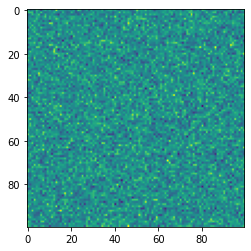

In [0]:
plt.imshow(noise)

DCGAN generates images from the noise. We can then display the images with plt.imshow.

In [0]:
images=generator(noise)

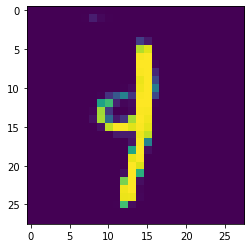

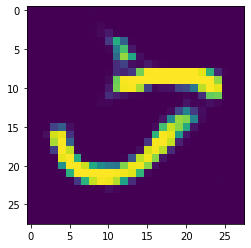

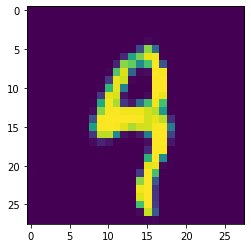

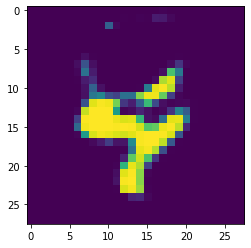

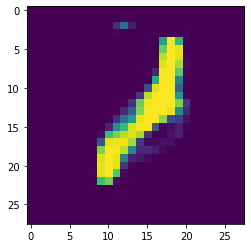

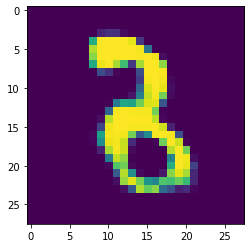

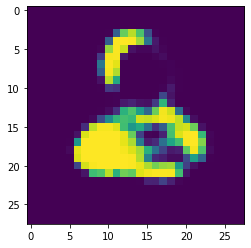

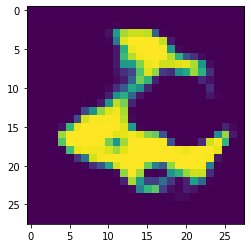

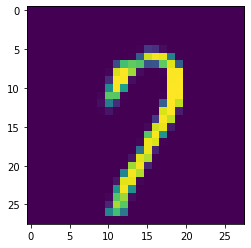

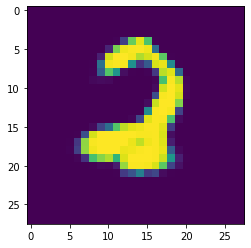

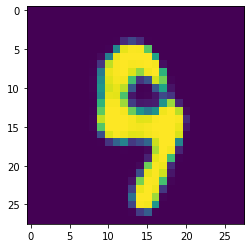

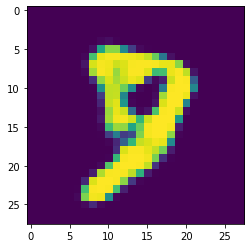

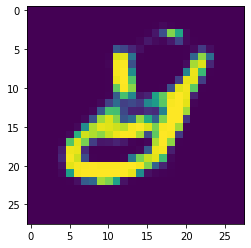

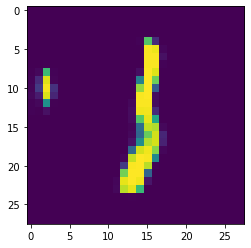

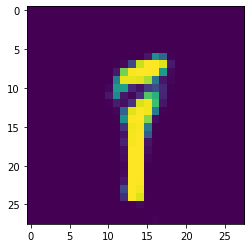

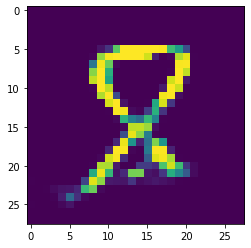

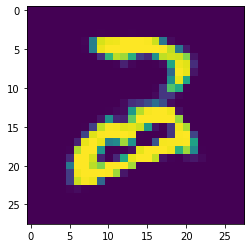

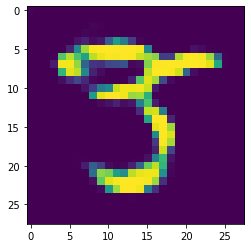

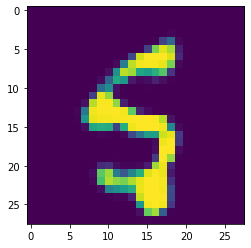

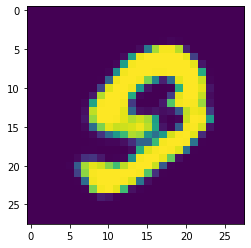

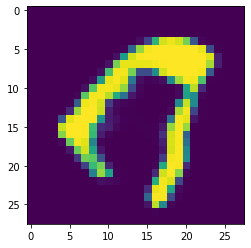

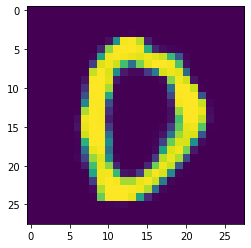

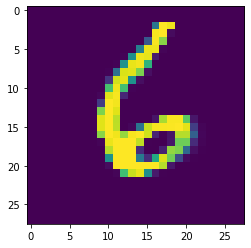

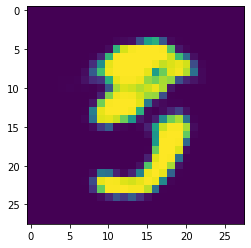

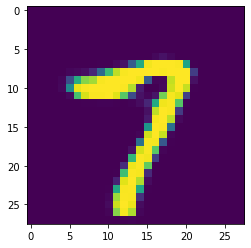

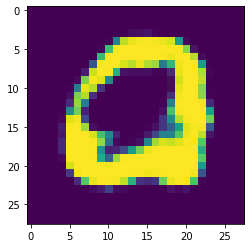

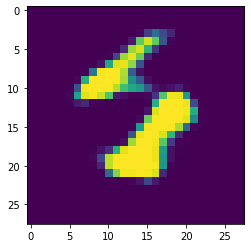

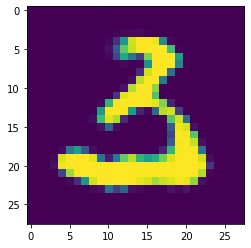

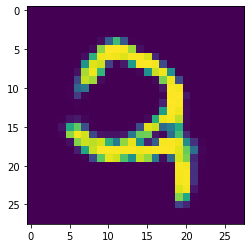

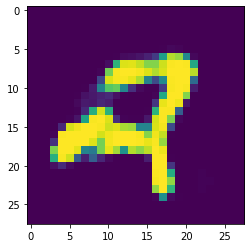

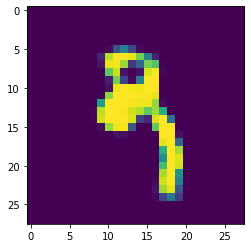

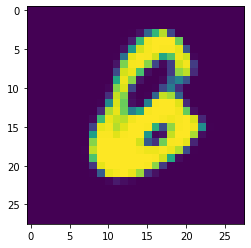

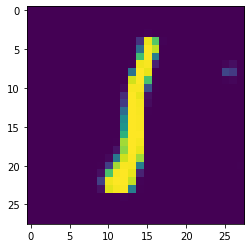

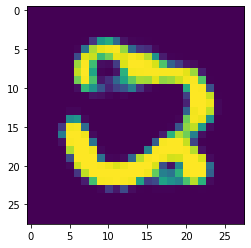

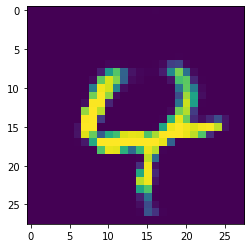

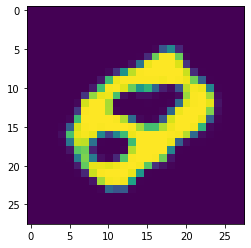

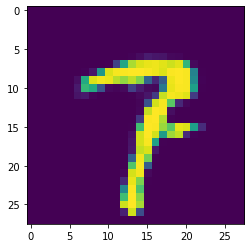

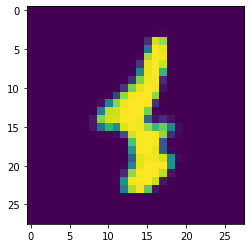

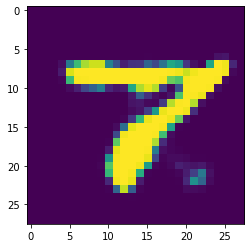

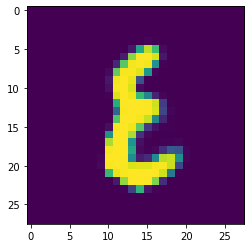

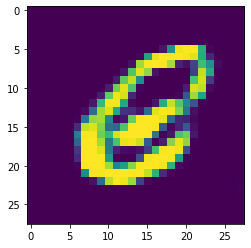

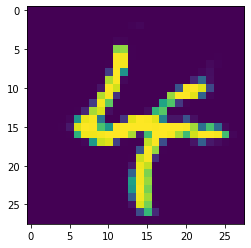

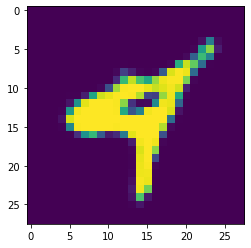

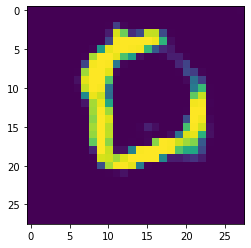

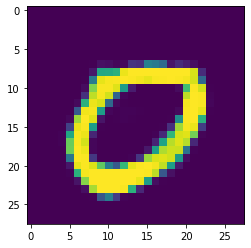

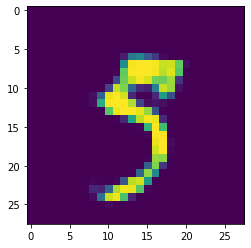

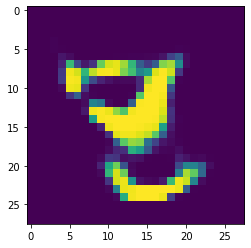

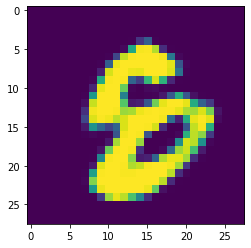

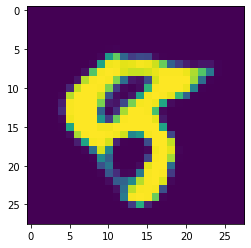

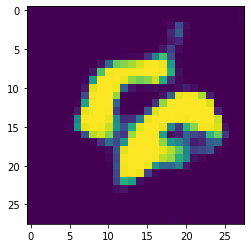

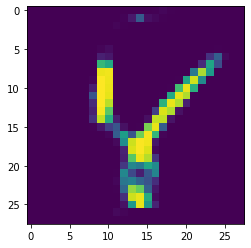

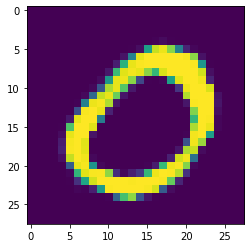

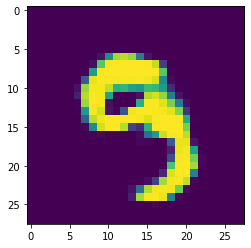

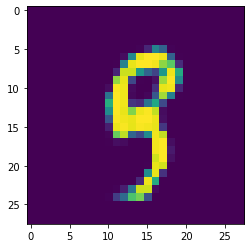

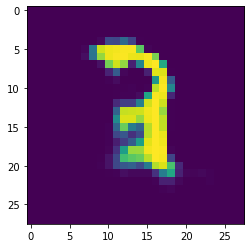

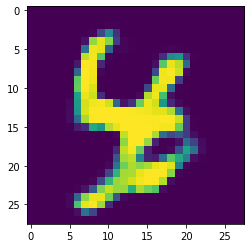

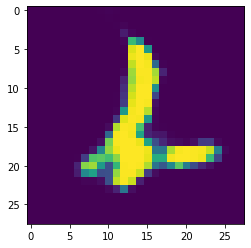

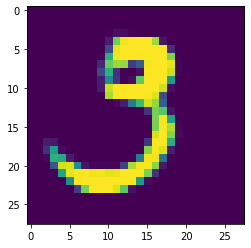

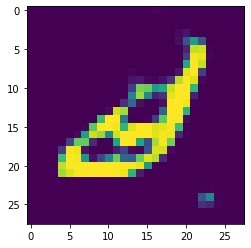

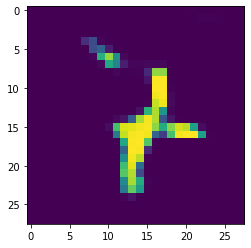

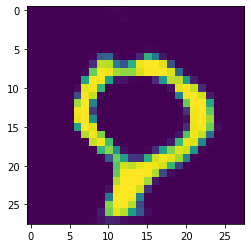

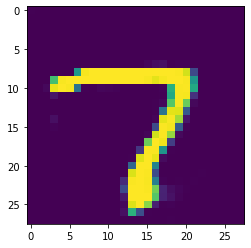

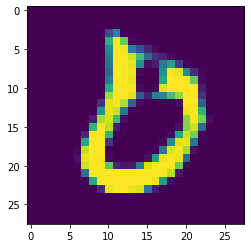

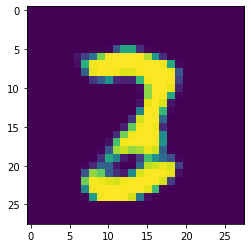

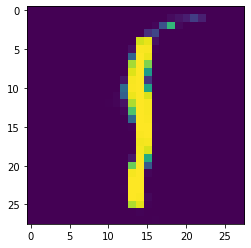

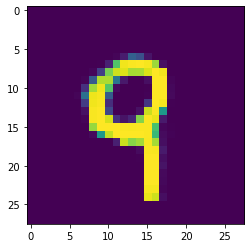

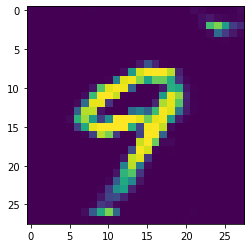

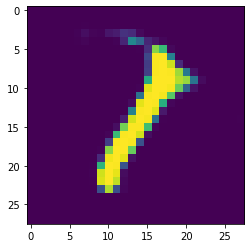

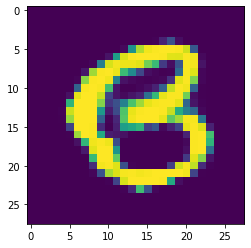

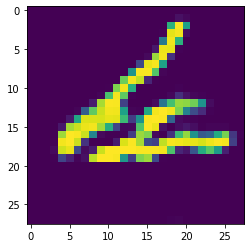

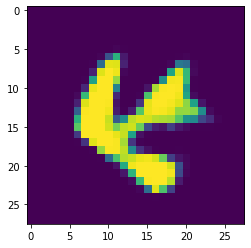

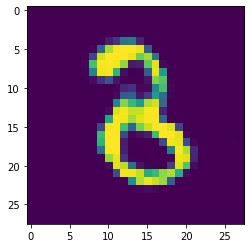

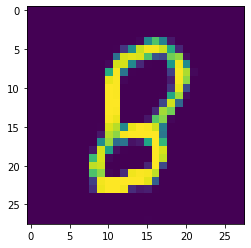

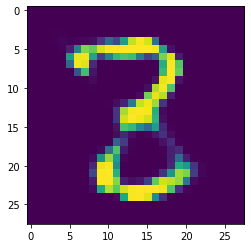

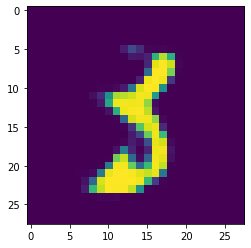

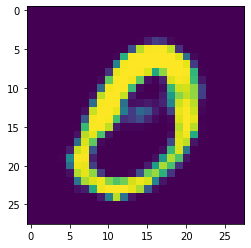

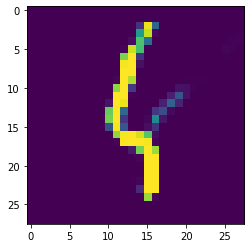

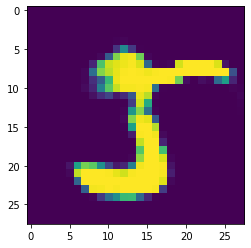

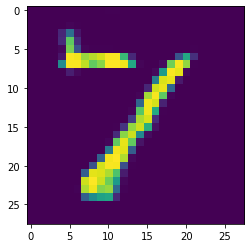

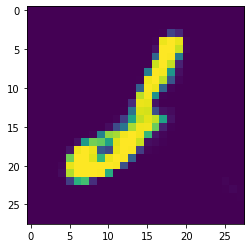

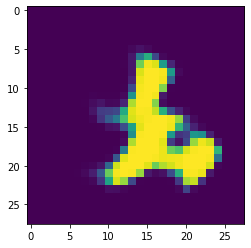

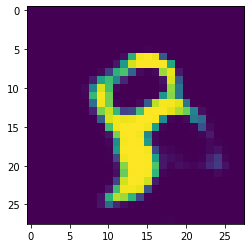

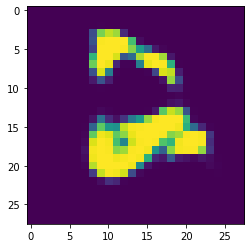

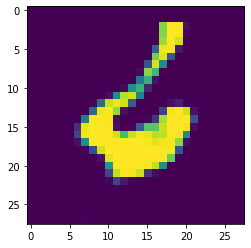

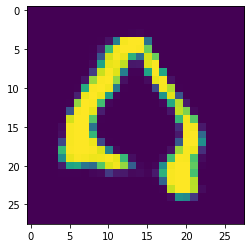

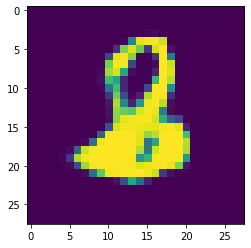

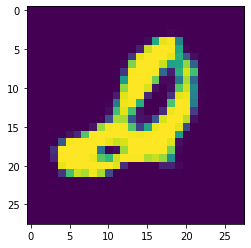

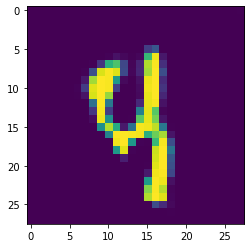

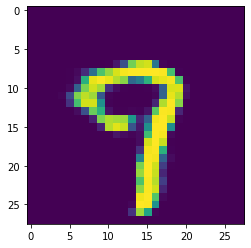

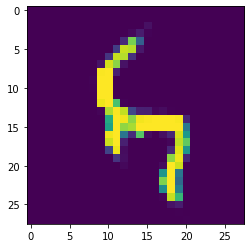

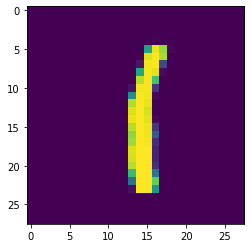

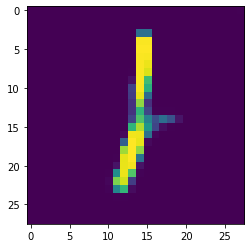

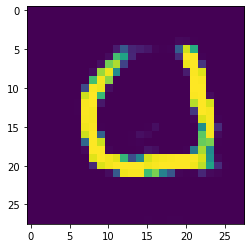

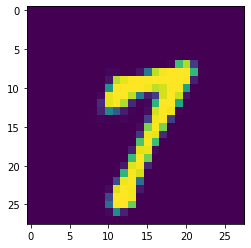

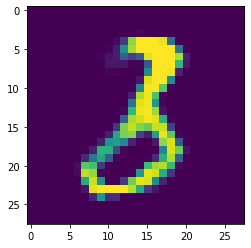

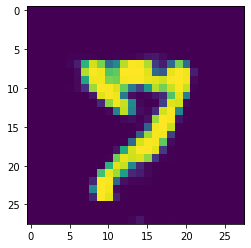

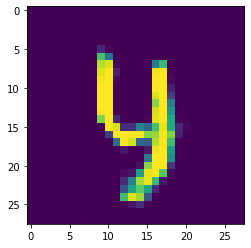

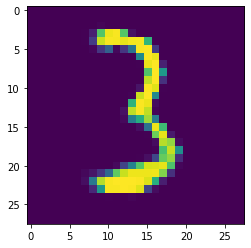

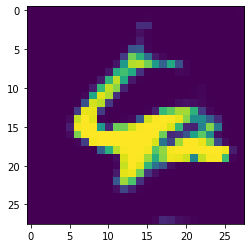

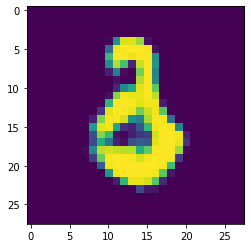

In [0]:
for image in images:
  plt.imshow(image.numpy().reshape(28,28))
  plt.show()